<a href="https://colab.research.google.com/github/MayerT1/LiDAR/blob/main/Draft_ALS_to_GEDI_DL_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
%cd /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/GEDI_DEV_GUAN

/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/GEDI_DEV_GUAN


In [4]:
!ls

als_to_gedi_treeheight_model.pth
Expanded_NEON_D04_GUAN_DP1_726000_1988000_classified_point_cloud.geojson
GEDI01_B_2019246042645_O04104_02_T00259_02_005_02_V002.h5
GEDI01_B_2020104212032_O07573_03_T01382_02_005_01_V002.h5
GEDI01_B_2020209182349_O09199_02_T03105_02_005_01_V002.h5
GEDI01_B_2020272172956_O10175_02_T05951_02_005_02_V002.h5
GEDI01_B_2020273024726_O10181_03_T07074_02_005_02_V002.h5
GEDI01_B_2020277011506_O10242_03_T08344_02_005_02_V002.h5
GEDI01_B_2020292190038_O10486_03_T08497_02_005_02_V002.h5
GEDI01_B_2021270173239_O15817_02_T03105_02_005_02_V002.h5
GEDI01_B_2021275011732_O15884_03_T08497_02_005_02_V002.h5
GEDI01_B_2022082051002_O18553_03_T04228_02_005_02_V002.h5
GEDI01_B_2022154150317_O19676_02_T05951_02_005_02_V002.h5
GEDI01_B_2022155002024_O19682_03_T01382_02_005_02_V002.h5
GEDI01_B_2022189012541_O20210_02_T00259_02_005_03_V002.h5
GEDI01_B_2022295072215_O21858_02_T07374_02_005_02_V002.h5
GEDI01_B_2023068100742_O24000_03_T08497_02_005_02_V002.h5
GEDI01_B_2023071231646_O

In [5]:
df = pd.read_csv("gedi_als_spatially_joined_within_25m.csv")  # Should have both ALS features and GEDI heights


# features = df.drop(columns=["rh98", "beam", "shot_number", "distance"]).values ## keeps Lidar_z
# targets = df["rh98"].values

X = df.drop(columns=["rh98", "beam", "shot_number", "distance"]).values ## keeps Lidar_z
y = df["rh98"].values


In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [22]:

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# print(X_scaled)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Dataset and loader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#print("train_loader", vars(train_loader))

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [23]:
class TreeHeightRegressor(nn.Module):
    def __init__(self, input_dim):
        super(TreeHeightRegressor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

model = TreeHeightRegressor(X_train.shape[1])


Epoch 000 | Train Loss: 1.6224 | Test Loss: 1.8511
Epoch 001 | Train Loss: 1.3068 | Test Loss: 1.8568
Epoch 002 | Train Loss: 1.6979 | Test Loss: 1.8605
Epoch 003 | Train Loss: 2.1222 | Test Loss: 1.8650
Epoch 004 | Train Loss: 1.3888 | Test Loss: 1.8710
Epoch 005 | Train Loss: 1.7942 | Test Loss: 1.8754
Epoch 006 | Train Loss: 2.0106 | Test Loss: 1.8794
Epoch 007 | Train Loss: 2.0379 | Test Loss: 1.8888
Epoch 008 | Train Loss: 2.4214 | Test Loss: 1.8947
Epoch 009 | Train Loss: 1.2809 | Test Loss: 1.9048
Epoch 010 | Train Loss: 0.9125 | Test Loss: 1.9207
Epoch 011 | Train Loss: 2.0035 | Test Loss: 1.9346
Epoch 012 | Train Loss: 1.3867 | Test Loss: 1.9493
Epoch 013 | Train Loss: 1.8926 | Test Loss: 1.9682
Epoch 014 | Train Loss: 1.8729 | Test Loss: 1.9877
Epoch 015 | Train Loss: 1.5752 | Test Loss: 2.0095
Epoch 016 | Train Loss: 1.5316 | Test Loss: 2.0093
Epoch 017 | Train Loss: 1.1467 | Test Loss: 2.0117
Epoch 018 | Train Loss: 1.1935 | Test Loss: 2.0133
Epoch 019 | Train Loss: 2.0157 

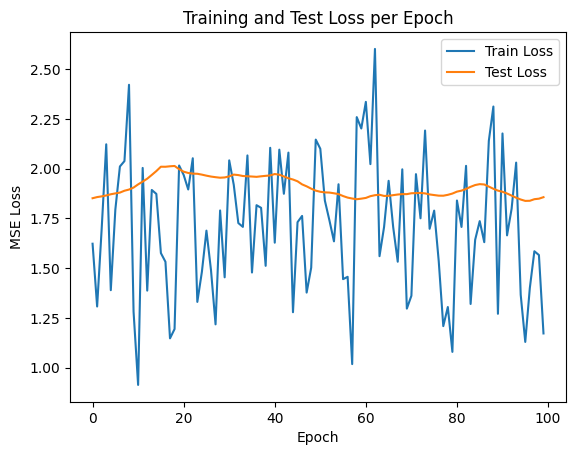

In [32]:
import matplotlib.pyplot as plt

# Initialize live plotting
plt.ion()
fig, ax = plt.subplots()
train_losses, test_losses = [], []
train_line, = ax.plot([], [], label='Train Loss')
test_line, = ax.plot([], [], label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Training and Test Loss per Epoch')
ax.legend()
fig.canvas.draw()
fig.show()

# Training loop
for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor).item()
        test_losses.append(test_loss)

    print(f"Epoch {epoch:03d} | Train Loss: {avg_train_loss:.4f} | Test Loss: {test_loss:.4f}")

    # Update the plot
    train_line.set_data(range(len(train_losses)), train_losses)
    test_line.set_data(range(len(test_losses)), test_losses)
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw()
    fig.canvas.flush_events()

# Final plot
plt.ioff()
plt.show()


In [37]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    mae = torch.mean(torch.abs(predictions - y_test_tensor))

print(f"\nTest MSE: {test_loss.item():.4f}")
print(f"Test MAE: {mae.item():.2f}")



Test MSE: 1.8903
Test MAE: 1.07


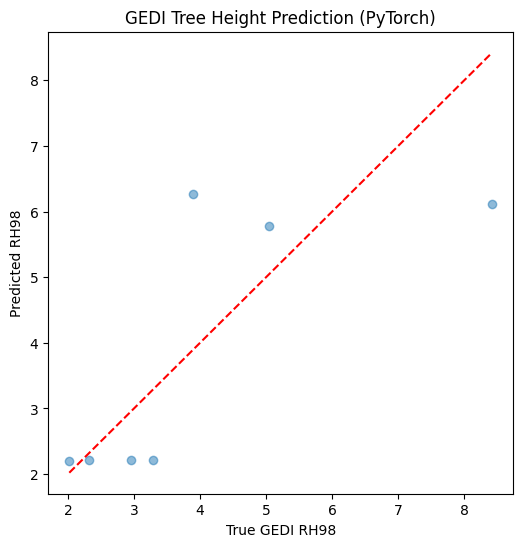

In [38]:
plt.figure(figsize=(6,6))
plt.scatter(y_test_tensor.numpy(), predictions.numpy(), alpha=0.5)
plt.xlabel('True GEDI RH98')
plt.ylabel('Predicted RH98')
plt.title('GEDI Tree Height Prediction (PyTorch)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.show()


In [39]:
# ---------- Save the Model ----------
torch.save(model.state_dict(), "als_to_gedi_treeheight_model.pth")